In [118]:
import pandas as pd
from sklearn.ensemble import IsolationForest
df = pd.read_csv("states.csv")
import matplotlib.pyplot as plt

In [119]:
!python -V

Python 3.9.6


In [120]:
iforest = IsolationForest(n_estimators=100).fit(df.iloc[:,1:])

In [121]:
iforestScores = iforest.score_samples(df.iloc[:,1:])

In [243]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [123]:
a = df.columns


In [124]:
import statsmodels.api as sm


In [125]:
df2 = pd.concat([pd.DataFrame(iforestScores),df],axis=1)

df2.columns = a.insert(0,"Anomaly")

In [273]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

regr = DecisionTreeRegressor(max_depth=5, random_state=1234)
X = df3
model = regr.fit(df2[a[1:]], abs(df2['Anomaly']))

# Print rules
rules = get_rules(regr, df2.columns, None)

In [274]:
rules

['if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) then response: 0.428 | based on 21 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty <= 84.15) then response: 0.455 | based on 13 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (States > 5.25) and (University > 62482.0) and (Infant Mort > 292.5) then response: 0.507 | based on 2 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (States > 5.25) and (University > 62482.0) and (Infant Mort <= 292.5) then response: 0.496 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White > 339.5) and (White <= 385.7) then response: 0.5 | based on 2 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (States > 5.25) and (University <= 62482.0) then response: 0.45 | based on 1 samples',
 'if (Poverty > 65.1) and (University > 59549.5) an

Index(['Poverty', 'Infant Mort', 'White', 'Crime', 'Doctors', 'Traf Deaths',
       'University', 'Unemployed', 'Income', 'Population'],
      dtype='object')

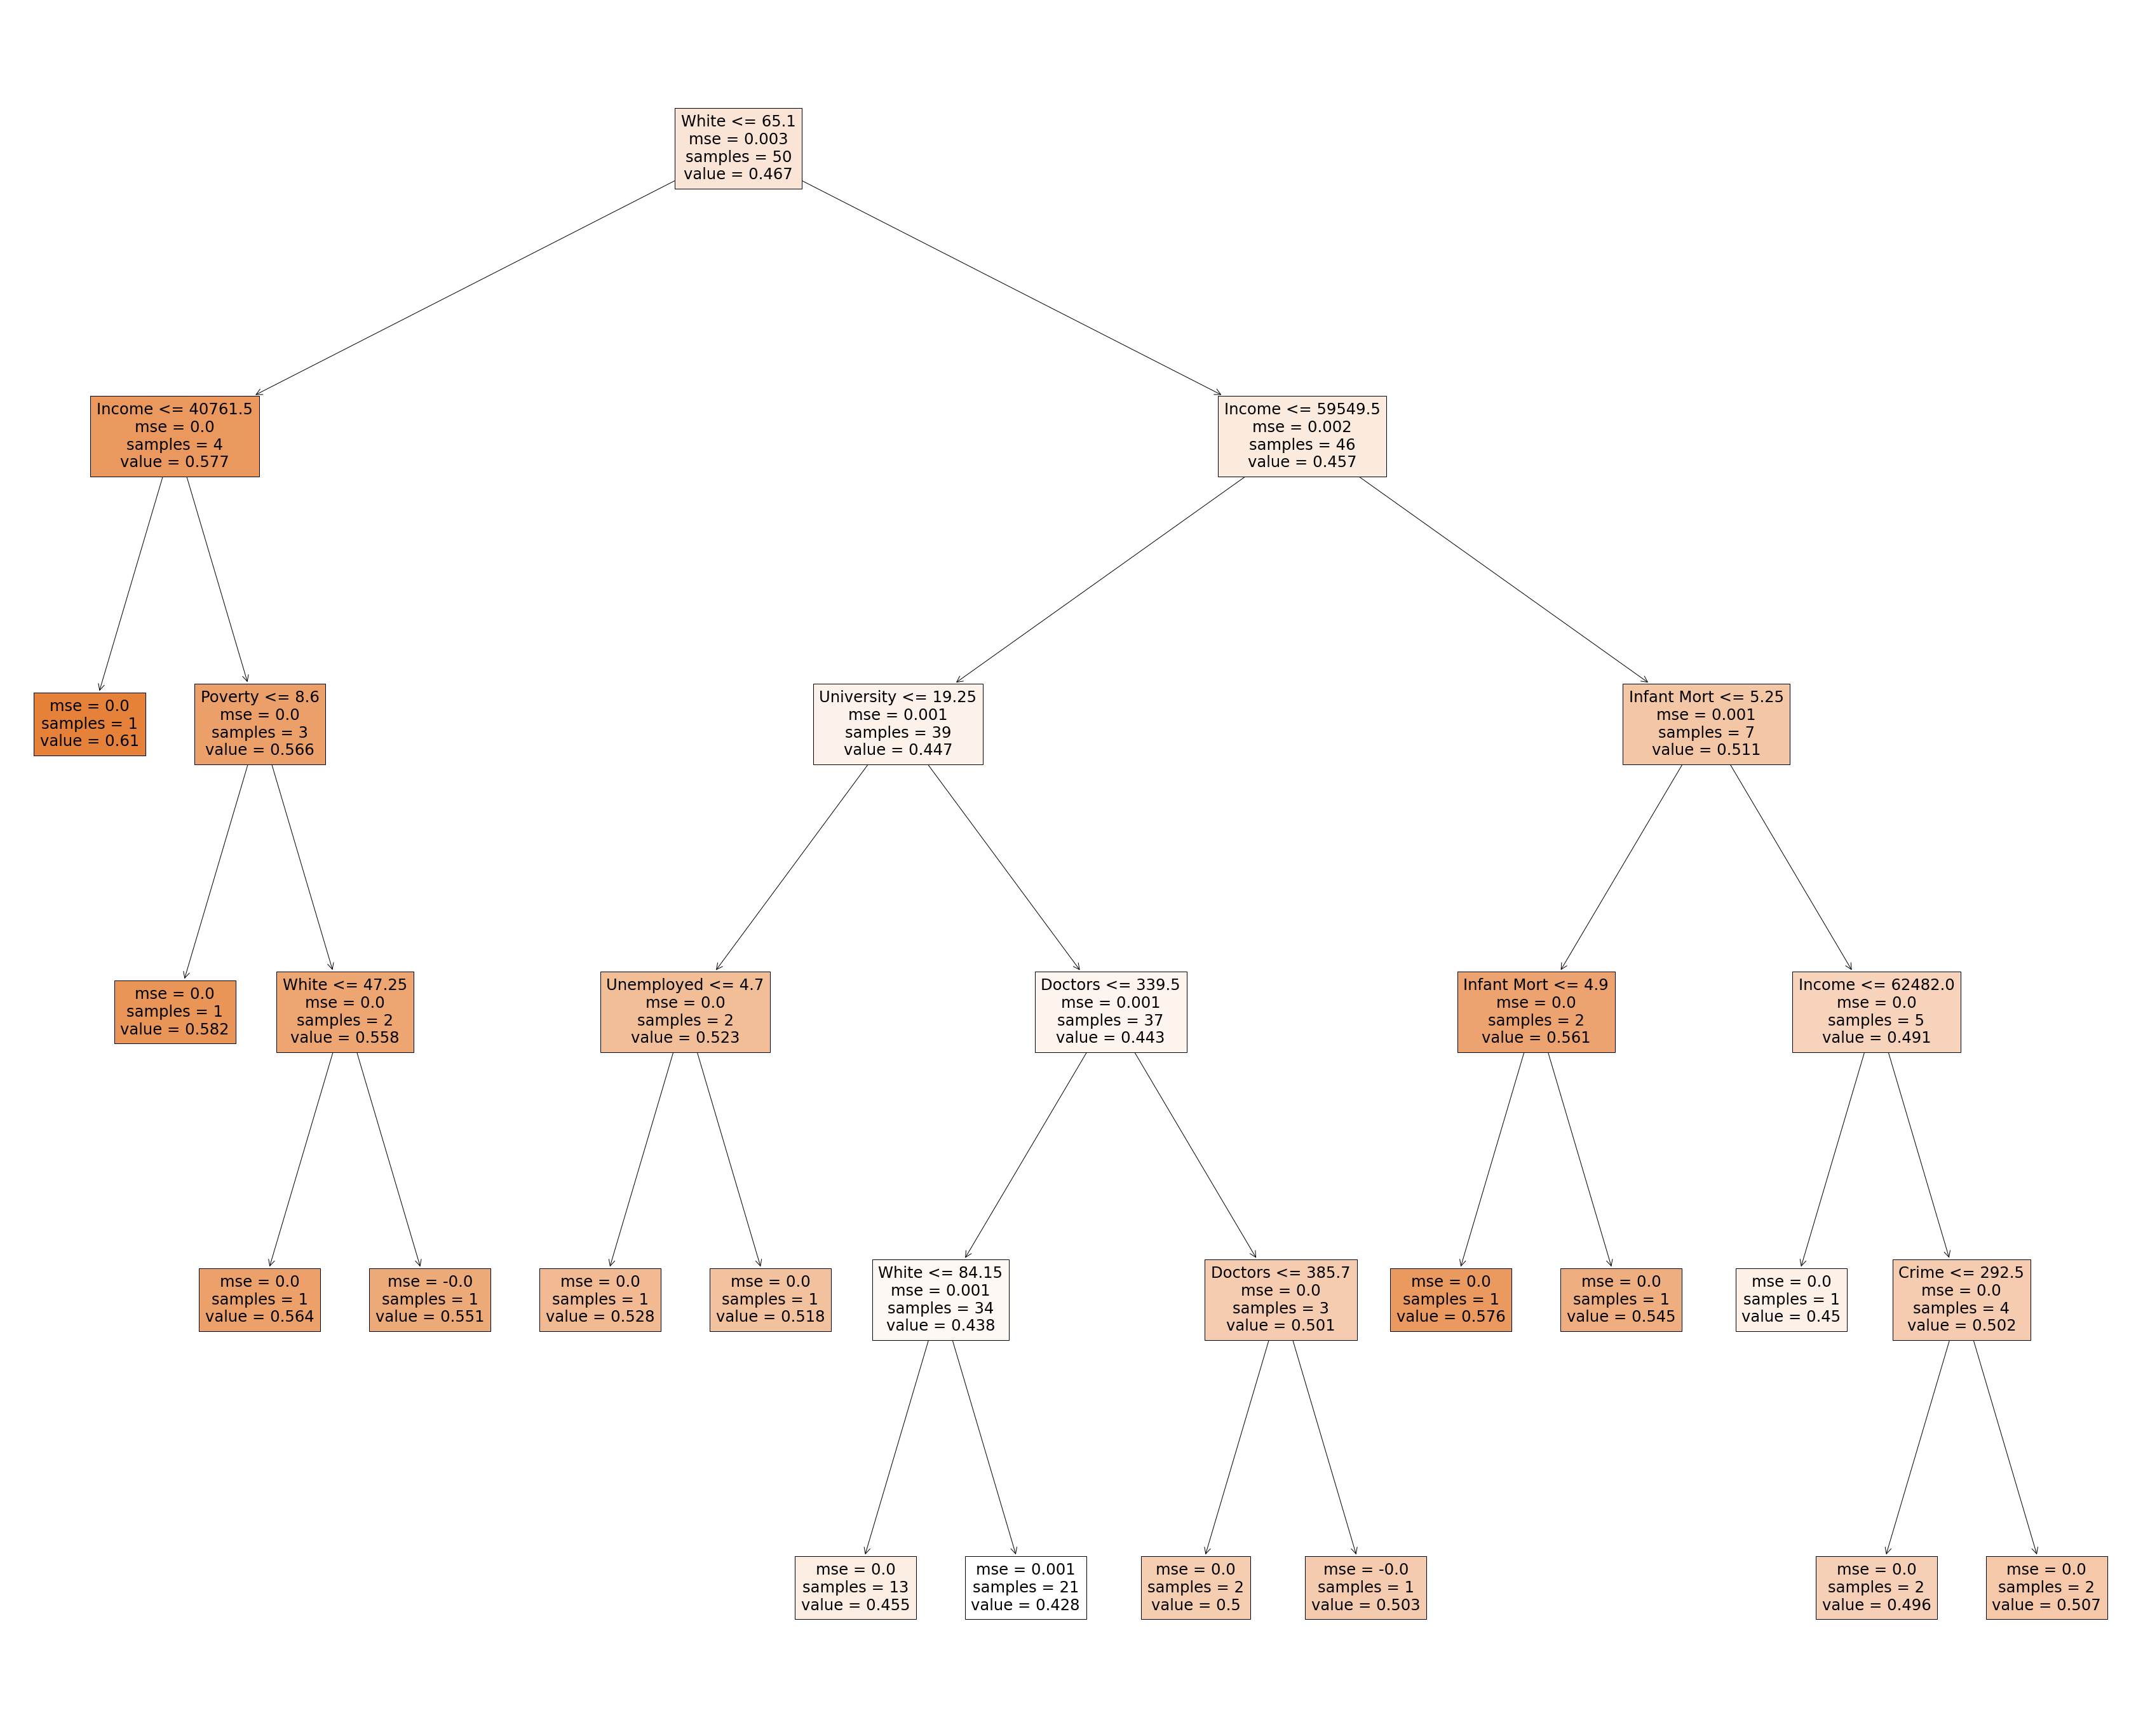

In [277]:
fig = plt.figure(figsize=(60,50))
_ = tree.plot_tree(regr, 
                   feature_names=a[1:],  
                   class_names=df2['States'],
                   filled=True)

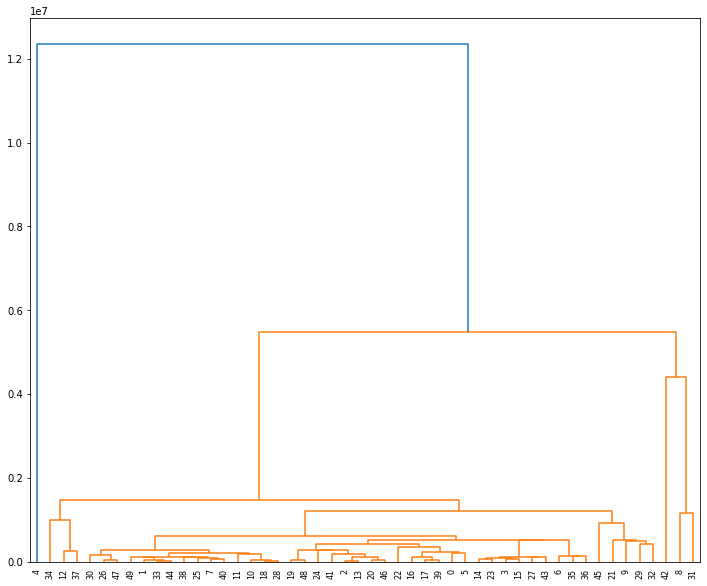

In [265]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(1, 2, )

ytdist = df2[a[1:]]
Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(12, 10))
dn = hierarchy.dendrogram(Z)

In [247]:
rules

['if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White <= 238.35) and (Poverty <= 94.05) and (Poverty > 89.05) and (Crime <= 2.125) then response: 0.468 | based on 3 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White > 238.35) and (States <= 6.35) and (University <= 53728.5) and (Unemployed > 1542247.0) then response: 0.414 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty > 84.15) and (Infant Mort <= 333.5) and (White > 238.35) and (States <= 6.35) and (University <= 53728.5) and (Unemployed <= 1542247.0) then response: 0.431 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Doctors > 19.25) and (White <= 339.5) and (Poverty <= 84.15) and (Crime <= 1.65) and (White <= 252.5

In [217]:
import imgkit

def highlight_greaterthan(x):
    if abs(x['Anomaly']) >= .6:
        return ['background-color: purple']*12
    elif abs(x['Anomaly']) >= .55:
        return ['background-color: red']*12
    elif abs(x['Anomaly']) >= .5:
        return ['background-color: yellow']*12
    else:
        return ['background-color: white']*12

html = df2.style.apply(highlight_greaterthan, axis=1).set_precision(2).render()

imgkit.from_string(html, 'state_anomalies.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

<AxesSubplot:>

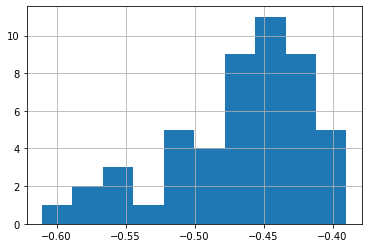

In [132]:
df2["Anomaly"].hist()